In [1]:
%matplotlib inline
import torch 
import torchvision
import torchvision.transforms.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from classifier.utils import data as data_utils
from torch.autograd import Variable
import os
import math
from simpleClassifier import simpleClassifier

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = data_utils.DatasetFromFile(data_path, train_data_file, 32, data_format = ".h5")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testset = data_utils.DatasetFromFile(data_path, test_data_file, 32, data_format = ".h5")
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img, gray= False):
    img = img/2+0.5 # unnormalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if gray:
        plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))

In [5]:
def convert_rgb_gray(inputs):
    inputs = inputs.numpy()
    inputs = np.mean(inputs,1)
    inputs = np.expand_dims(inputs, axis=1)
    inputs = torch.from_numpy(inputs)
    return inputs

 bird deer ship frog deertruck ship bird deer  cat ship deer bird  cat  cartruck


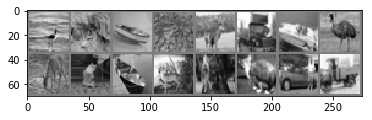

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = convert_rgb_gray(images)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(16)))

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = init_lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
net = simpleClassifier()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

In [10]:
net.cuda()
for epoch in range(300):
    running_loss = 0.0
    adjust_learning_rate(optimizer, epoch, 0.05)
    for i, data in enumerate(trainloader, 0):
        # get the inputs 
        inputs, labels = data
        inputs = convert_rgb_gray(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics 
        running_loss +=loss
        if i%2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finished training')

[1,  2000] loss: 2.041
[2,  2000] loss: 2.011
[3,  2000] loss: 2.016
[4,  2000] loss: 2.008
[5,  2000] loss: 2.000
[6,  2000] loss: 1.997
[7,  2000] loss: 1.986
[8,  2000] loss: 1.996
[9,  2000] loss: 2.008
[10,  2000] loss: 2.013
[11,  2000] loss: 2.021
[12,  2000] loss: 2.038
[13,  2000] loss: 2.041
[14,  2000] loss: 2.035
[15,  2000] loss: 2.043
[16,  2000] loss: 2.039
[17,  2000] loss: 2.045
[18,  2000] loss: 2.068
[19,  2000] loss: 2.038
[20,  2000] loss: 2.047
[21,  2000] loss: 2.055
[22,  2000] loss: 2.071
[23,  2000] loss: 2.040
[24,  2000] loss: 2.065
[25,  2000] loss: 2.070
[26,  2000] loss: 2.061
[27,  2000] loss: 2.051
[28,  2000] loss: 2.059
[29,  2000] loss: 2.039
[30,  2000] loss: 2.044
[31,  2000] loss: 1.904
[32,  2000] loss: 1.851
[33,  2000] loss: 1.810
[34,  2000] loss: 1.794
[35,  2000] loss: 1.785
[36,  2000] loss: 1.785
[37,  2000] loss: 1.771
[38,  2000] loss: 1.782
[39,  2000] loss: 1.768
[40,  2000] loss: 1.752
[41,  2000] loss: 1.733
[42,  2000] loss: 1.711
[

Ground truth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


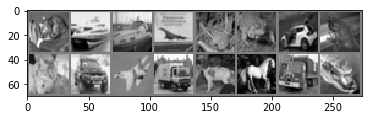

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = convert_rgb_gray(images)

# print images 
imshow(torchvision.utils.make_grid(images), gray=True)
print('Ground truth: ', ' '.join('%5s'% classes[labels[j]] for j in range(16)))

In [12]:
images = Variable(images).cuda()
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu()
predicted = predicted.data.numpy()
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(16)))

Predicted:   frog truck plane plane   cat  frog plane  deer  deer  frog  deer truck  bird horse truck plane


In [14]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images = convert_rgb_gray(images)
    images = Variable(images).cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu()
    total +=labels.size(0)
    correct +=(predicted==labels).sum()
accuracy = int(100*correct/total)        
print('Accuracy of the network on the 10000 test images: %d %%', 100*correct/total)

Accuracy of the network on the 10000 test images: %d %% 56.67


In [15]:
def save_model(model, optimizer, path = "/", filename = 'check_point.pth'):
    torch.save({'model':model.state_dict(), 'optimizer':optimizer.state_dict()}, os.path.join(path, filename))

In [16]:
save_model(net, optimizer, path="/home/snagesh/git/classifier/trainedModels/", filename="default_modelsimpleClassifier"+str(accuracy)+".pth")